## Computer lab: Principal Component Analysis (PCA) on goat SNP data

This exercise is build around a dataset from Colli et al. Genet Sel Evol (2018) 50:58 https://doi.org/10.1186/s12711-018-0422-x and lecture notes from Genomics Boot Camp, an online course by Gábor Mészáros.

### Population Structure within Goats

Today we will do a principal component analysis (PCA) based on quality-controlled genotype data. And as you probably guessed from the title we will look a goat data today. But before jumping into the exciting world of goats. Let's look at the PCA in general, but try to keep it on a high level of abstraction (read; let's try to avoid the math for now).

### The Principal Component Analysis

Principal Component Analysis (PCA) is a powerful statistical technique employed in population genetics to unravel genetic variation within and among populations. By reducing the complexity of genetic data into a few orthogonal axes, named Principal Components. These axes are then ordered by the amounts of variation explained by that linear combination of variables. The math behind it are, I geuss a bit beyond the scope of this course, but it will be covered in Statistical and Machine Learning in Bioinformatics in the spring.

### The Goats

The PCA itself is a way to visualize complex systems in a simple way. In our case, we want to show relationships between the worldwide goat populations genotyped in the ADAPTmap project. After the quality control, we have 4532 animals left. If we compute genetic distances (with PLINK), we get a matrix of 4532 by 4532 animals, with more than 10 million pairwise combinations. So a "rather" long list to scroll through, let alone make sense of it. Fortunately, we can apply some clever statistical methods to simplify it for us. We will lose some precision and nuances about the relationships between breeds, but in exchange, we can see everything in one figure.

### The Packages
You can again install all dependencies from the `env.yaml` file as follows:
```bash
mamba env create -f env.yaml
```
For those of you who have problems setting up the environment, the notebook is also hosted on [Google Colab](https://colab.research.google.com/drive/1ilgzhFTFvcDdseU2_BO53xiKp7YZVOts?usp=sharing).

We start by downloading the data from the GitHub repository. The data is stored in a zip file, which we will download and unzip.

In [39]:
import os
import zipfile

import requests
from tqdm import tqdm


def download_file(url: str, dest: str):
    """
    Download a file from a url and save it to a destination

    :param url: URL to download from
    :param dest: Destination to save the file to
    """
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    with open(dest, 'wb') as f:
        for chunk in tqdm(response.iter_content(chunk_size=8192), total=total_size / 8192,
                          unit='MB', unit_scale=8192 / (1024 * 1024), desc="Downloading"):
            f.write(chunk)


def unzip(zip_file: str):
    """
    Unzip a file to a destination

    :param zip_file: Path to the zip file
    """
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()


url = ("https://github.com/Bjarke-M/Evolutionary_Thinking_2024/blob/"
       "fb17582a10b81c6b8ef9641222eb012a69c227fb/week44/Friday/data.zip?raw=true")

dest = os.getcwd() + "/goats.zip"
download_file(url, dest)
unzip(dest)

43.7578125MB [00:12,  3.52MB/s]                                       


### PLINK

To process the data, we will use a program called PLINK, which is a free, open-source whole genome association analysis toolset, designed to perform a range of basic, large-scale analyses in a computationally efficient manner. You can read more about it here:\[https://zzz.bwh.harvard.edu/plink/\]. More precisely, we will use the Python wrapper for PLINK, called pandas-plink. pandas-plink is a Python library for reading PLINK files into native Python data structures using pandas and dask. You can read more about it here: \[https://pandas-plink.readthedocs.io/en/latest/].

We obtain three files: bed, bim, and fam.

In [40]:
from pandas_plink import read_plink

(bim, fam, bed) = read_plink(os.getcwd() + "/data/snps")

Mapping files:   0%|          | 0/3 [00:00<?, ?it/s]/var/folders/w6/18ktl5312413jw46btlxrh59fzxvt4/T/ipykernel_85991/3470272502.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (bim, fam, bed) = read_plink(os.getcwd() + "/data/snps")
/var/folders/w6/18ktl5312413jw46btlxrh59fzxvt4/T/ipykernel_85991/3470272502.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (bim, fam, bed) = read_plink(os.getcwd() + "/data/snps")
Mapping files: 100%|██████████| 3/3 [00:22<00:00,  7.59s/it]


### BIM file
The bim file contains information about the SNPs in the dataset, and is made available as a pandas DataFrame.

In [41]:
bim.head()

,chrom,snp,cm,pos,a0,a1,i
0,0,snp10134-scaffold1361-15149,0.0,0,A,G,0
1,0,snp10135-scaffold1361-44576,0.0,0,A,G,1
2,0,snp10136-scaffold1361-91495,0.0,0,G,A,2
3,0,snp10412-scaffold1372-579082,0.0,0,0,G,3
4,0,snp10413-scaffold1372-610565,0.0,0,G,A,4


### FAM file
The fam file contains information about the individuals in the dataset, and is also made available as a pandas DataFrame.

In [42]:
fam.head()

,fid,iid,father,mother,gender,trait,i
0,ABR,ET_ABR0001,0,0,0,-9,0
1,ABR,ET_ABR0002,0,0,0,-9,1
2,ABR,ET_ABR0003,0,0,0,-9,2
3,ABR,ET_ABR0004,0,0,0,-9,3
4,ABR,ET_ABR0005,0,0,0,-9,4


### BED file
The bed file contains the genotype data per SNP and individual which we will mainly work with. This file is potentially large, and made available as a dask array. Dask is a flexible library for parallel computing in Python. It allows you to break up arrays into smaller chunks, which can be computed in parallel. This is useful when working with large datasets that do not fit into memory. The interface is similar to NumPy, so you can use it as a drop-in replacement in many cases. Operations on dask arrays are lazy, meaning that they are not computed until you explicitly ask for the result. This allows you to build up complex computations without running out of memory. You can read more about it here: \[https://docs.dask.org/en/stable/array.html]. We can evaluate the query by calling the compute() method, which will return a NumPy array.

In [43]:
# get the first 5 rows (SNPs) and 5 columns (individuals) of the bed file
bed[:5, :5].compute()

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [ 1.,  0.,  1.,  1.,  1.],
       [nan, nan, nan, nan, nan],
       [ 2.,  2.,  2.,  2.,  2.]], dtype=float32)

### Quality control and filtering

We first need to filter the data to remove SNPs and individuals with too many missing genotypes. We will also remove SNPs with a minor allele frequency (MAF) below 0.05. The filtering will be done with dask arrays.

In [44]:
import dask.array as da

# Drop mitochondrial and sex chromosome SNPs based on your data’s chromosome annotations
# Filter chromosomes in bim DataFrame
autosomal_snps = bim['chrom'].astype(int) <= 29
bed_filtered = bed[autosomal_snps]

Question: Why would we want to drop mitochondrial and sex chromosome SNPs?  

In [45]:
# Filter individuals (axis=1) with >5% missing SNPs
bed_filtered = bed[:, da.isnan(bed).mean(axis=0) <= 0.05]

# Filter SNPs (axis=0) with >5% missing genotypes
bed_filtered = bed_filtered[da.isnan(bed_filtered).mean(axis=1) <= 0.05, :]

Question: Why would we want to filter individuals with >5% missing SNPs and SNPs with >5% missing genotypes?

In [46]:
# Filter SNPs with MAF < 0.05
maf = da.nanmean(bed_filtered, axis=1) / 2
bed_filtered = bed_filtered[(maf >= 0.05) & (maf <= 0.95), :]

Question: Why would we want to filter SNPs with MAF < 0.05? What is the MAF and why do we divide by 2 in the calculation?

In [47]:
# perform computation and obtain numpy array
bed_filtered = bed_filtered.compute()

Before we can perform the PCA, we need to impute the missing values. We will use the mean value to fill in the missing values.

In [48]:
from sklearn.impute import SimpleImputer

# Fit and transform the data to fill NaNs
# You can change the strategy to 'median', 'most_frequent', or 'constant'
bed_imputed = SimpleImputer(strategy='mean').fit_transform(bed_filtered)

Question: Why would we want to impute the missing values before performing the PCA? What does strategy='mean' mean?

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Number of components to keep
pca_result = pca.fit_transform(bed_imputed.T)

# Get explained variance
explained_variance = pca.explained_variance_ratio_ * 100

We can now visualize the principal components in a scatter plots. We focus on the first two principal components, which explain the most variance in the data. We also show the percentage of variance explained by each component on the axes.

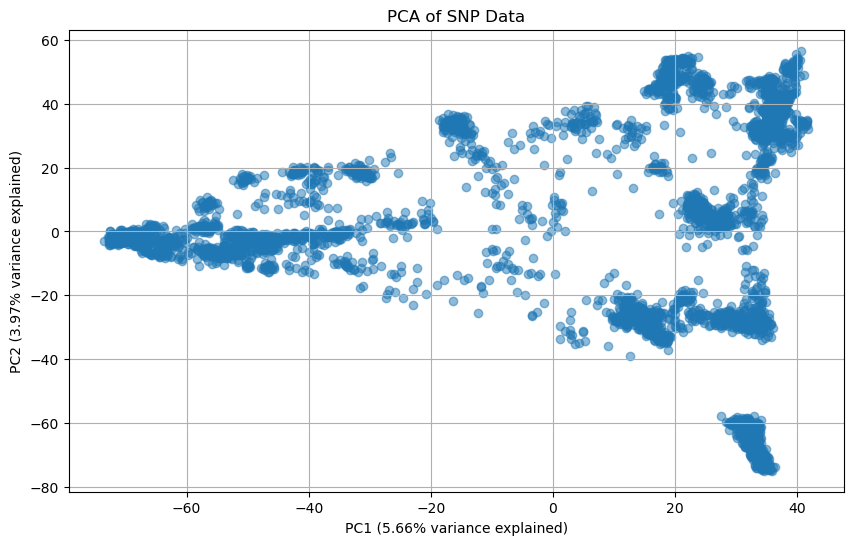

In [51]:
import matplotlib.pyplot as plt

# Plot PCA
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

plt.title('PCA of SNP Data')
plt.xlabel(f'PC1 ({explained_variance[0]:.2f}% variance explained)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2f}% variance explained)')
plt.grid()
plt.show()

Question: What does each point in the scatter plot represent? What do the axes represent? What does the percentage of variance explained by each component mean?

Question: How does the explained variance compare to the paper? What could be the reasons for the differences?

Question: What evolutionary explanations causes populations structure? and Can you see an overall pattern to the goat populations?

Optional question: How does the population structure of the first two principal components and explained variance change if we apply more stringent missing value filtering or MAF filtering?

Optional question: How does the PCA change if we only consider mitochondrial and sex chromosome SNPs?

Optional question: What if we visualize the first vs. the third principal component instead of the first two? Compare with the paper.

Optional question: Does the PCA change for different imputation strategies?

Optional question: What is the minimum number of principal components needed to explain 50% of the total variance?

Additional information: Because PCAs is such a fast and easy way to gain valuable insights, one should be careful with the interpretations based in PCAs alone: https://www.nature.com/articles/s41598-022-14395-4